# Temporal Difference Method

**Run env - Run on Local Jupyter Notebook**

In [1]:
#Preprae the enviroenment & install the required libraries
import sys
import gym
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)


is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Mountain Car Environment

```
A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.
```

In [2]:
# Create the OpenGYM environment
import sys
import gym
import numpy as np

# Create the Panda environment
import pandas as pd

# Install visualization module
import matplotlib.pyplot as plt
env = gym.make('MountainCar-v0')
env.seed(0);

print(vars(env), end='\n\n')
print(dir(env))

{'env': <gym.envs.classic_control.mountain_car.MountainCarEnv object at 0x00000295CBBBAD30>, 'action_space': Discrete(3), 'observation_space': Box(-1.2000000476837158, 0.6000000238418579, (2,), float32), 'reward_range': (-inf, inf), 'metadata': {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 30}, '_max_episode_steps': 200, '_elapsed_steps': None}

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_elapsed_steps', '_max_episode_steps', 'action_space', 'class_name', 'close', 'compute_reward', 'env', 'metadata', 'observation_space', 'render', 'reset', 'reward_range', 'seed', 'spec', 'step', 'unwrapped']


In [3]:
print(env.observation_space)
print(env.action_space)

Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Discrete(3)


In [4]:
print("low:", env.observation_space.low)
print("high:", env.observation_space.high)

low: [-1.2  -0.07]
high: [0.6  0.07]


In [5]:
random_state = env.reset()
print('Random State', random_state)

random_action = env.action_space.sample()
print('Random Action', random_action)

Random State [-0.589  0.   ]
Random Action 2


## Random Action Agent

Score:  200


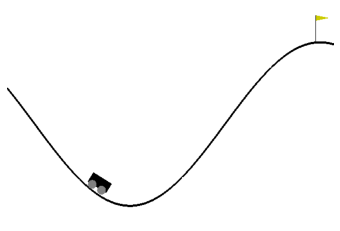

In [6]:
import imageio
images = []

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action = env.action_space.sample()
    frame = env.render(mode='rgb_array')
    images.append(frame)
    img.set_data(frame)  
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        print('Score: ', t+1)
        break


imageio.mimsave('1_random_agent.gif', images)
env.close()

## Discretizing the Continuous State Space to Discrete Space
As the TD Learning works on discrete space, we have to convert the environment state spance into discrete space.
Methods like
- Tile Encoding
- Coarse Encoding 
can be used for discretizing the space.

In [7]:
def create_uniform_grid(low, high, bins=(10, 10)):
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] for dim in range(len(bins))]
    print("Uniform grid: [<low>, <high>] / <bins> => <splits>")
    for l, h, b, splits in zip(low, high, bins, grid):
        print("    [{}, {}] / {} => {}".format(l, h, b, splits))
    return grid

def discretize(sample, grid):
    return list(int(np.digitize(s, g)) for s, g in zip(sample, grid))

In [8]:
grid = create_uniform_grid([-1.0, -5.0], [1.0, 5.0])
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ 1.0 ,  5.0]])
discretized_samples = np.array([discretize(sample, grid) for sample in samples])
print("\nSamples:", repr(samples), sep="\n")
print("\nDiscretized samples:", repr(discretized_samples), sep="\n")

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [-1.0, 1.0] / 10 => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]

Samples:
array([[-1.  , -5.  ],
       [-0.81, -4.1 ],
       [-0.8 , -4.  ],
       [-0.5 ,  0.  ],
       [ 0.2 , -1.9 ],
       [ 0.8 ,  4.  ],
       [ 0.81,  4.1 ],
       [ 1.  ,  5.  ]])

Discretized samples:
array([[0, 0],
       [0, 0],
       [1, 1],
       [2, 5],
       [5, 3],
       [9, 9],
       [9, 9],
       [9, 9]])


# Sarsa(0) or Temporal Difference

 - Agents are trained only for 30000 episodes.
 Mathematical Representation to explain the difference between TD & Q Learning -

TD learning uses the behaviour policy the policy used by the agent to generate experience in the environment, which is typically epsilon-greedy) to select an additional action At+1, and then uses Q(St+1, At+1) (discounted by gamma) as expected future returns in the computation of the update target.

In [9]:
class Sarsa:
    def __init__(self, env, state_grid, alpha=0.05, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=505):
        # Environment info
        self.env = env
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid) 
        self.action_size = self.env.action_space.n  
        self.seed = np.random.seed(seed)
        print("Environment:", self.env)
        print("State space size:", self.state_size)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon
        
        # Create Q-table
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("Q table size:", self.q_table.shape)

    def preprocess_state(self, state):
        return tuple(discretize(state, self.state_grid))

    def reset_episode(self, state):
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)
        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon
    
    def get_probs(self, Q_s, epsilon, nA):
        policy_s = np.ones(nA) * epsilon / nA
        best_a = np.argmax(Q_s)
        policy_s[best_a] = 1 - epsilon + (epsilon / nA)
        return policy_s

    def act(self, state, epsilon, reward=None, done=None, mode='train'):
        state = self.preprocess_state(state)
        nA = self.env.action_space.n
        if mode == 'test':
            # Test mode: Simply produce an action
            action = np.argmax(self.q_table[state])
        else:
            sarsa_action = np.random.choice(np.arange(nA), p=get_probs(self.q_table[state], epsilon, nA)) \
                                    if state in self.q_table else env.action_space.sample()
            self.q_table[self.last_state + (self.last_action,)] += self.alpha * \
                (reward + self.gamma * self.q_table[state][sarsa_action]- self.q_table[self.last_state + (self.last_action,)])

            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the best action from Q table
                action = np.argmax(self.q_table[state])
        self.last_state = state
        self.last_action = action
        return action
    
    def run(self, env, num_episodes=20000, mode='train', eps_start=1.0, eps_decay=.99999, eps_min=0.05):
        scores = []
        max_avg_score = -np.inf
        epsilon = eps_start
        for i_episode in range(1, num_episodes+1):
            # Initialize episode
            state = env.reset()
            action = self.reset_episode(state)
            total_reward = 0
            done = False

            # Roll out steps until done
            while not done:
                state, reward, done, info = env.step(action)
                total_reward += reward
                epsilon = max(epsilon*eps_decay, eps_min)
                action = self.act(state, epsilon, reward, done, mode)

            # Save final score
            scores.append(total_reward)

            # Print episode stats
            if mode == 'train':
                if len(scores) > 100:
                    avg_score = np.mean(scores[-100:])
                    if avg_score > max_avg_score:
                        max_avg_score = avg_score
                if i_episode % 100 == 0:
                    print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                    sys.stdout.flush()

        return scores

In [10]:
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(20, 20))    
sarsa_agent = Sarsa(env, state_grid)
scores = sarsa_agent.run(env, num_episodes=30000)

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [-1.2000000476837158, 0.6000000238418579] / 20 => [-1.11 -1.02 -0.93 -0.84 -0.75 -0.66 -0.57 -0.48 -0.39 -0.3  -0.21 -0.12 -0.03  0.06  0.15  0.24  0.33  0.42  0.51]
    [-0.07000000029802322, 0.07000000029802322] / 20 => [-0.063 -0.056 -0.049 -0.042 -0.035 -0.028 -0.021 -0.014 -0.007  0.     0.007  0.014  0.021  0.028  0.035  0.042  0.049
  0.056  0.063]
Environment: <TimeLimit<MountainCarEnv<MountainCar-v0>>>
State space size: (20, 20)
Action space size: 3
Q table size: (20, 20, 3)


<ipython-input-9-71648a26095a>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if state in self.q_table else env.action_space.sample()


Episode 30000/30000 | Max Average Score: -131.81

###  Performance of TD Learning
  -  **The below graph is showing how the  agent is actually learning in TD Learing method.**
  -  **The scores vs rolling mean is plotted to find the underlying trend of the learning of the agent.**

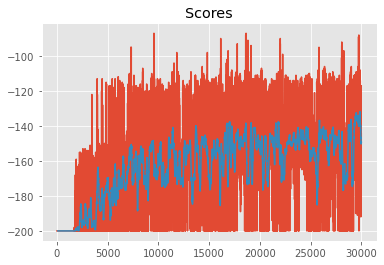

In [11]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores)

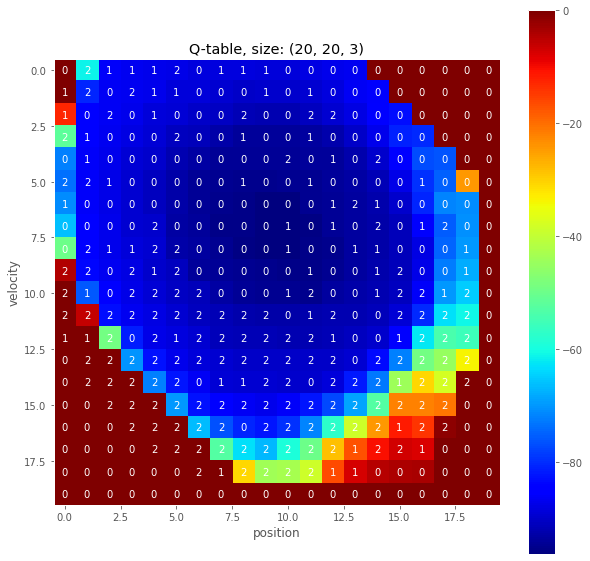

In [12]:
def plot_q_table(q_table):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table, axis=2)       # max Q-value for each state
    q_actions = np.argmax(q_table, axis=2)  # best action for each state

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap='jet');
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x, y, q_actions[x, y], color='white',
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')


plot_q_table(sarsa_agent.q_table)

Score:  -140.0


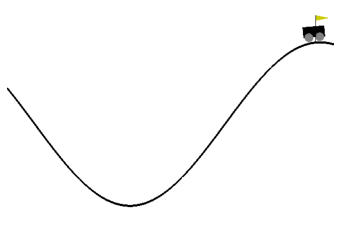

In [13]:
import imageio
images = []

state = env.reset()
score = 0
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action = sarsa_agent.act(state, epsilon=0, mode='test')
    frame = env.render(mode='rgb_array')
    images.append(frame)
    img.set_data(frame) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    score += reward
    if done:
        print('Score: ', score)
        break
        
env.close()
imageio.mimsave('1_sarsa_agent.gif', images)

## Sarsamax or Q-learning
Q-learning does not use the behaviour policy to select an additional action At+1. Instead, it estimates the expected outcome or future returns in the update rule as maxA Q(St+1, A). The max operator used here can be viewed as "following" the completely greedy policy. The agent is not actually following the greedy policy though; it only says, in the update rule, "suppose that I would start following the greedy policy from now on, what would my expected future returns be then?".


In [14]:
class QLearningAgent:
    def __init__(self, env, state_grid, alpha=0.05, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=505):
        """Initialize variables, create grid for discretization."""
        # Environment info
        self.env = env
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid)  # n-dimensional state space
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        print("Environment:", self.env)
        print("State space size:", self.state_size)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon
        
        # Create Q-table
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("Q table size:", self.q_table.shape)

    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        # TODO: Implement this
        return tuple(discretize(state, self.state_grid))

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)

        # Decide initial action
        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        state = self.preprocess_state(state)
        if mode == 'test':
            # Test mode: Simply produce an action
            action = np.argmax(self.q_table[state])
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair with current state, reward
            self.q_table[self.last_state + (self.last_action,)] += self.alpha * \
                (reward + self.gamma * max(self.q_table[state]) - self.q_table[self.last_state + (self.last_action,)])

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the best action from Q table
                action = np.argmax(self.q_table[state])

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action
    
    def run(self, env, num_episodes=20000, mode='train'):
        """Run agent in given reinforcement learning environment and return scores."""
        scores = []
        max_avg_score = -np.inf
        for i_episode in range(1, num_episodes+1):
            # Initialize episode
            state = env.reset()
            action = self.reset_episode(state)
            total_reward = 0
            done = False

            # Roll out steps until done
            while not done:
                state, reward, done, info = env.step(action)
                total_reward += reward
                action = self.act(state, reward, done, mode)

            # Save final score
            scores.append(total_reward)

            # Print episode stats
            if mode == 'train':
                if len(scores) > 100:
                    avg_score = np.mean(scores[-100:])
                    if avg_score > max_avg_score:
                        max_avg_score = avg_score
                if i_episode % 100 == 0:
                    print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                    sys.stdout.flush()

        return scores

In [15]:

state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(20, 20))    
q_agent = QLearningAgent(env, state_grid)
scores = q_agent.run(env, num_episodes=30000)

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [-1.2000000476837158, 0.6000000238418579] / 20 => [-1.11 -1.02 -0.93 -0.84 -0.75 -0.66 -0.57 -0.48 -0.39 -0.3  -0.21 -0.12 -0.03  0.06  0.15  0.24  0.33  0.42  0.51]
    [-0.07000000029802322, 0.07000000029802322] / 20 => [-0.063 -0.056 -0.049 -0.042 -0.035 -0.028 -0.021 -0.014 -0.007  0.     0.007  0.014  0.021  0.028  0.035  0.042  0.049
  0.056  0.063]
Environment: <TimeLimit<MountainCarEnv<MountainCar-v0>>>
State space size: (20, 20)
Action space size: 3
Q table size: (20, 20, 3)
Episode 30000/30000 | Max Average Score: -122.61

#### Performance of Q Learning
  -  **The below graph is showing how the  agent is actually learning in Q Learing method.**
  -  **The scores vs rolling mean is plotted to find the underlying trend of the learning of the agent.**
  


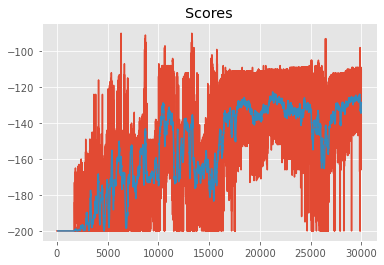

In [16]:
rolling_mean = plot_scores(scores)

## Plotting Q table

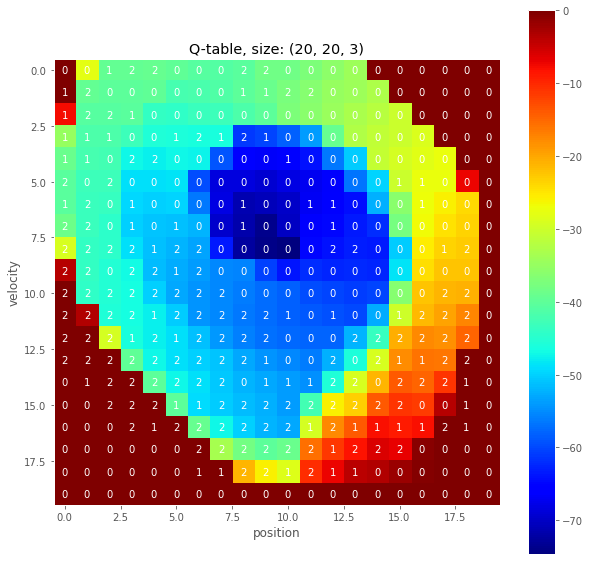

In [17]:
#Visualize the Q-table of the TD- Learning Process
plot_q_table(q_agent.q_table)

Score:  -111.0


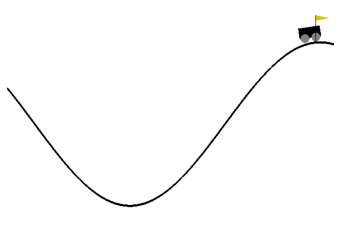

In [18]:
import imageio
images = []

state = env.reset()
score = 0
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action = q_agent.act(state, mode='test')
    frame = env.render(mode='rgb_array')
    images.append(frame)
    img.set_data(frame) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    score += reward
    if done:
        print('Score: ', score)
        break
        
env.close()
imageio.mimsave('2_qlearning_agent.gif', images)

# Expected Sarsa

In [19]:
class ExpectedSarsa:
    def __init__(self, env, state_grid, alpha=0.05, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=505):
        self.env = env
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid)  # n-dimensional state space
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        print("Environment:", self.env)
        print("State space size:", self.state_size)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon
        
        # Create Q-table
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("Q table size:", self.q_table.shape)

    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        # TODO: Implement this
        return tuple(discretize(state, self.state_grid))

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)

        # Decide initial action
        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon
    
    def get_probs(self, Q_s, epsilon, nA):
        policy_s = np.ones(nA) * epsilon / nA
        best_a = np.argmax(Q_s)
        policy_s[best_a] = 1 - epsilon + (epsilon / nA)
        return policy_s

    def act(self, state, epsilon, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        state = self.preprocess_state(state)
        nA = self.env.action_space.n
        if mode == 'test':
            # Test mode: Simply produce an action
            action = np.argmax(self.q_table[state])
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair with current state, reward
            self.q_table[self.last_state + (self.last_action,)] += self.alpha * \
                (reward + self.gamma * np.dot(self.get_probs(self.q_table[state], epsilon, nA), self.q_table[state]) - self.q_table[self.last_state + (self.last_action,)])

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the best action from Q table
                action = np.argmax(self.q_table[state])

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action
    
    def run(self, env, num_episodes=20000, mode='train', eps_start=1.0, eps_decay=.99999, eps_min=0.05):
        """Run agent in given reinforcement learning environment and return scores."""
        scores = []
        max_avg_score = -np.inf
        epsilon = eps_start
        for i_episode in range(1, num_episodes+1):
            # Initialize episode
            state = env.reset()
            action = self.reset_episode(state)
            total_reward = 0
            done = False

            # Roll out steps until done
            while not done:
                state, reward, done, info = env.step(action)
                total_reward += reward
                epsilon = max(epsilon*eps_decay, eps_min)
                action = self.act(state, epsilon, reward, done, mode)

            # Save final score
            scores.append(total_reward)

            # Print episode stats
            if mode == 'train':
                if len(scores) > 100:
                    avg_score = np.mean(scores[-100:])
                    if avg_score > max_avg_score:
                        max_avg_score = avg_score
                if i_episode % 100 == 0:
                    print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                    sys.stdout.flush()

        return scores

In [20]:
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(20, 20))    
e_sarsa_agent = ExpectedSarsa(env, state_grid)
scores = e_sarsa_agent.run(env, num_episodes=30000)

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [-1.2000000476837158, 0.6000000238418579] / 20 => [-1.11 -1.02 -0.93 -0.84 -0.75 -0.66 -0.57 -0.48 -0.39 -0.3  -0.21 -0.12 -0.03  0.06  0.15  0.24  0.33  0.42  0.51]
    [-0.07000000029802322, 0.07000000029802322] / 20 => [-0.063 -0.056 -0.049 -0.042 -0.035 -0.028 -0.021 -0.014 -0.007  0.     0.007  0.014  0.021  0.028  0.035  0.042  0.049
  0.056  0.063]
Environment: <TimeLimit<MountainCarEnv<MountainCar-v0>>>
State space size: (20, 20)
Action space size: 3
Q table size: (20, 20, 3)
Episode 30000/30000 | Max Average Score: -122.82

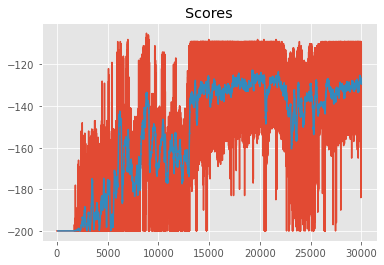

In [21]:
rolling_mean = plot_scores(scores)

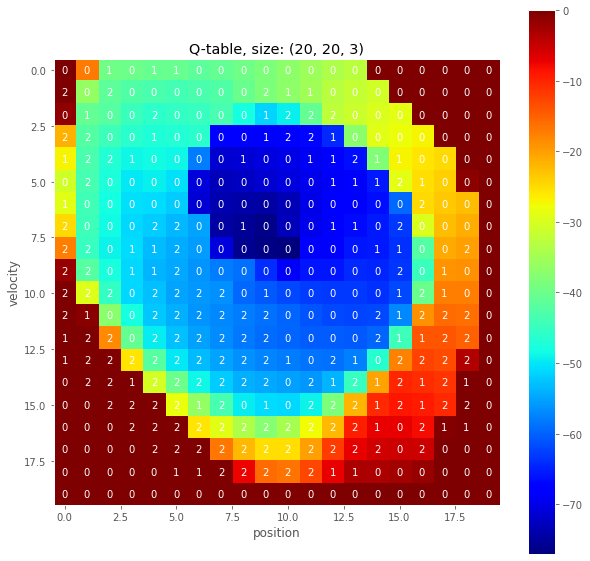

In [22]:
#Visualize the Q-table of the Q- Learning Process
plot_q_table(e_sarsa_agent.q_table)

Score:  -137.0


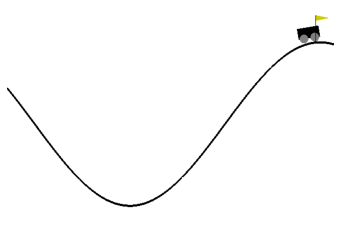

In [23]:
import imageio
images = []

state = env.reset()
score = 0
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action = e_sarsa_agent.act(state, epsilon=0, mode='test')
    frame = env.render(mode='rgb_array')
    images.append(frame)
    img.set_data(frame) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    score += reward
    if done:
        print('Score: ', score)
        break
        
env.close()
imageio.mimsave('3_expected_sarsa_agent.gif', images)